### **3D Protein Image Classification Model**
Image Classification Model that identifies proteins given an mrc file. Credit to [Tensorflow's documentation](https://www.tensorflow.org/tutorials/images/classification) for how to create an image segmentation model using their library.

In [1]:
# run on python 3.9.6
# import the following libraries to use for the model and visualizing its accuracy and loss
import matplotlib.pyplot as plt
import mrcfile
import numpy as np
import os
import pathlib
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### **Download + Explore the Dataset**

In [2]:
data_dir = "../../mrc/atlas-mrc"
data_dir = pathlib.Path(data_dir)

### **Process .mrc files**

In [3]:
batch_size = 32
img_height = img_width = img_depth = 100

In [20]:
def load_mrc_files_from_directory(directory):
    mrc_files = []
    labels = []

    # Iterate over subdirectories (classes)
    class_names = sorted(os.listdir(directory))
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            # Iterate over .mrc files in the current class directory
            for filename in sorted(os.listdir(class_dir)):
                if filename.endswith('.mrc'):
                    file_path = os.path.join(class_dir, filename)
                    # Load .mrc file
                    with mrcfile.open(file_path) as mrc:
                        mrc_data = mrc.data.astype(np.float32)
                        mrc_files.append(mrc_data)
                        labels.append(class_index)

    return mrc_files, labels, class_names

In [21]:
def mrc_dataset_from_directory(directory, batch_size=32, validation_split=None, seed=123):
    # Load .mrc files from directory
    mrc_files, labels, class_names = load_mrc_files_from_directory(directory)

    # Convert lists to TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((mrc_files, labels))

    if validation_split:
        # Determine sizes of training and validation sets
        num_samples = len(mrc_files)
        num_validation_samples = int(validation_split * num_samples)
        num_training_samples = num_samples - num_validation_samples

        # Shuffle and split dataset into training and validation sets
        dataset = dataset.shuffle(num_samples, seed=seed)
        train_dataset = dataset.take(num_training_samples)
        validation_dataset = dataset.skip(num_training_samples)
        validation_dataset = validation_dataset.take(num_validation_samples)

        return train_dataset, validation_dataset, class_names
    else:
        # Shuffle and batch the dataset
        dataset = dataset.shuffle(len(mrc_files), seed=seed).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        return dataset, class_names

In [23]:
train_ds, val_ds, class_names = mrc_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    validation_split=0.2,
    seed=123
)

### **Load data using a Keras utility**

In [24]:
print(f"There are {len(train_ds)} mrc files for training.")
print(f"There are {len(val_ds)} mrc files for validation.")

There are 24 mrc files for training.
There are 6 mrc files for validation.


In [25]:
print(class_names)

['bltp2', 'coagulation', 'rif1']


### **Visualize the Data**

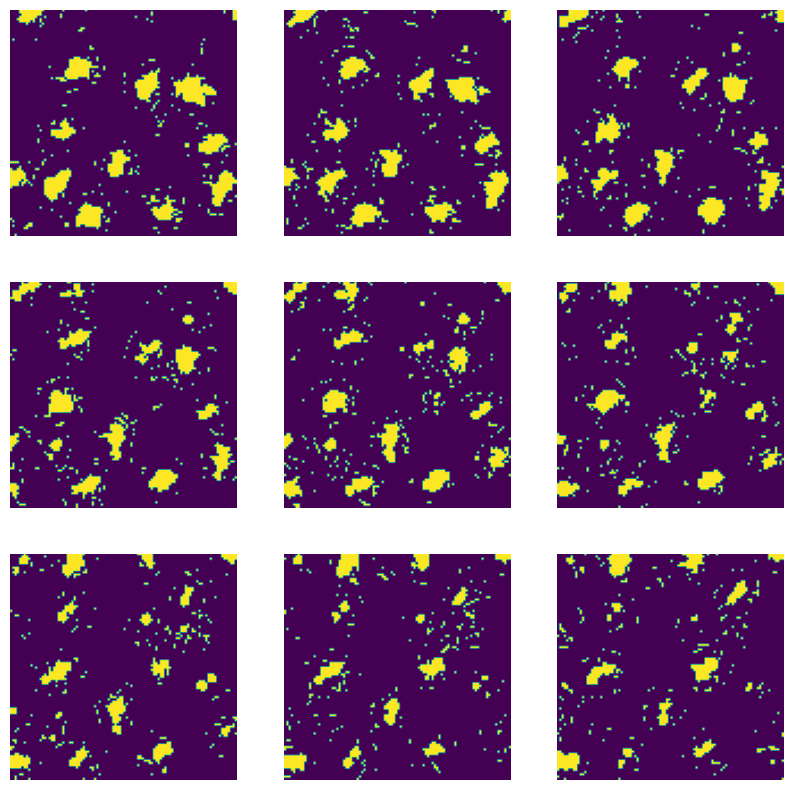

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    plt.axis("off")

### **Configure the dataset for performance**

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Standardize the Data**

In [30]:
normalization_layer = layers.Rescaling(1./255)

In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.003921569


### **TensorFlow Keras Model**

In [34]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times.

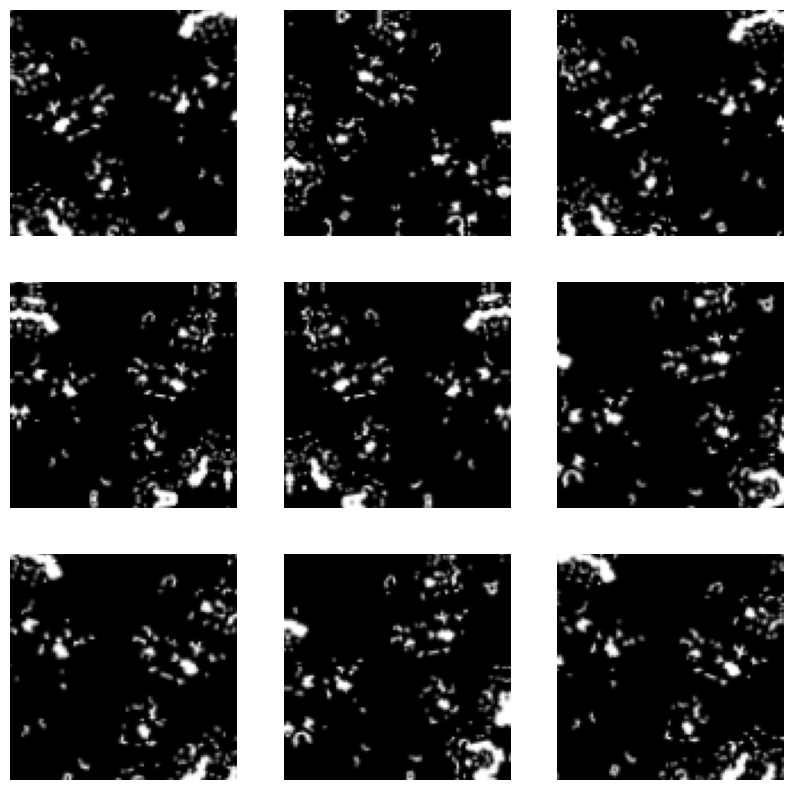

In [15]:
plt.figure(figsize=(10, 10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**<br>

In [35]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv3D(16, (3, 3, 3), padding='same', activation='relu'),
  layers.MaxPooling3D((2, 2, 2)),
  layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu'),
  layers.MaxPooling3D((2, 2, 2)),
  layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu'),
  layers.MaxPooling3D((2, 2, 2)),
  layers.Conv3D(128, (3, 3, 3), padding='same', activation='relu'),
  layers.MaxPooling3D((2, 2, 2)),
  layers.Dropout(0.6),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

**Compile and Train the Model**

In [36]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# filename='callbacks_log.csv'
# history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [39]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
def expand_dims_fn(data, label):
    data = np.expand_dims(data, axis=0)
    return data, label

In [41]:
train_ds = train_ds.map(expand_dims_fn)
val_ds = val_ds.map(expand_dims_fn)

In [42]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type _PrefetchDataset).

In [22]:
import csv
d = history.history

n = len(d["loss"])
with open("callbacks_log.csv", "w") as f:
    csv_writer = csv.writer(f, lineterminator="\n")
    header = ["epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
    csv_writer.writerow(header)

    for i in range(n):
        loss = d["loss"][i]
        accuracy = d["accuracy"][i]
        val_loss = d["val_loss"][i]
        val_accuracy = d["val_accuracy"][i]
        csv_writer.writerow([i, loss, accuracy, val_loss, val_accuracy])

**Visualize Training Results**

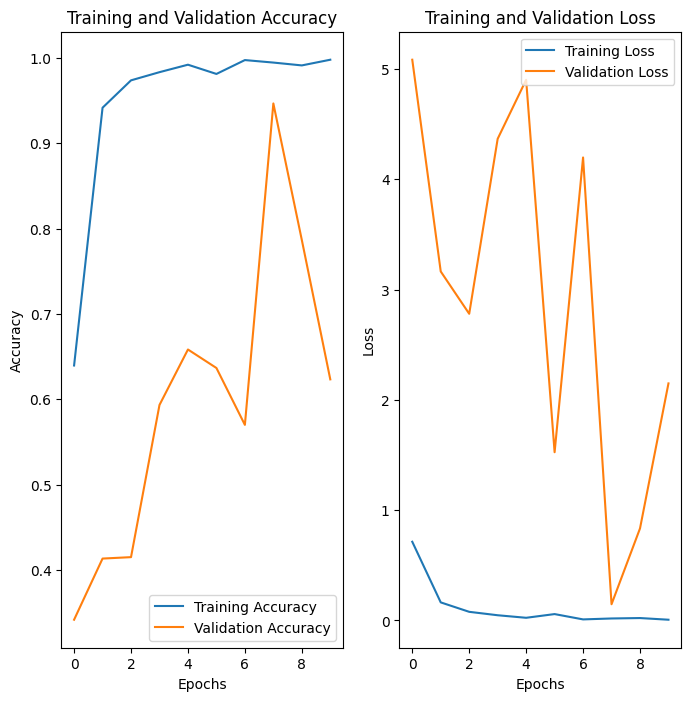

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.show()

### **Predict on New Data**

In [25]:
test_path = "coagulation_model_slice_094.png"

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
This image most likely belongs to rif1 with a 100.00 percent confidence.


### **Save the Model**

In [27]:
model.save('atlas_model.keras')